# ΙΑΚΩΒΟΣ ΕΥΔΑΙΜΩΝ p3130059 ΤΜΗΜΑ: ΠΛΗΡΟΦΟΡΙΚΗΣ


# Exploring Why Civil Resistance Works

In this assignment, you will replicate some of the findings of a well-received book, [Why Civil Resistance Works](https://www.ericachenoweth.com/research/wcrw) by [Erical Chenoweth](https://www.ericachenoweth.com/) and Maria J. Stephan. The two authors examined whether nonviolent campaigns are more effective than violent campaigns. They found that yes; from a data set containing details of campaigns from 1900 onwards, they found that in general peaceful campaigns are more effective in achieving their aims than violent ones.

To answer the following questions you will use the data that the authors helpfully provide at <https://www.ericachenoweth.com/wp-content/uploads/2012/01/Data-and-Replication-Files-3.zip>. The data is in Stata format, which pandas can read without a problem. To understand the data, read the documentation at <https://www.ericachenoweth.com/wp-content/uploads/2019/07/WCRW-Appendix.pdf> (in particular, Table WA.7).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr

In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import math
%matplotlib inline

## 1. Frequency of Nonviolent and Violent Campaign End Years

Create a plot showing the frequency of nonviolent and violent campaigns; the frequency should be counted based on their end years, at decades. The violent and nonviolent campaign counts should be stacked on each other.

Your plot should look like the following:

<img src="fig_1.svg"/>

# Answer 1 :

Διαβάζουμε το αρχείο και δημιουργούμε το dataframe με την βοήθεια του pandas. Εκτυπώνουμε τις 5 πρώτες παρατηρήσεις του dataframe

In [2]:
data = pd.io.stata.read_stata('WCRWreplication.dta')
data.head()

,defect,outcome,peakmembership,eyear,byear,location,campaign,target,lccode,tccode,...,lmtnest,ef,loclpolity1,loclcap1,loclcap2,loclcap3,loclcap4,mempc,demdum,recur1
0,1.0,5,50000.0,1959,1956,Cuba,Cuban Revolution,Batista regime,40.0,40.0,...,1.694107,0.2134,-9.0,0.0,1.0,0.0,0.0,1.226839,0.0,0.0
1,0.0,3,5000.0,1920,1918,Haiti,Caco Revolt,U.S. occupation,41.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,1.0,5,30000.0,1985,1985,Haiti,,Jean Claude Duvalier,41.0,41.0,...,2.797281,0.0950,-9.0,1.0,0.0,0.0,0.0,1.200712,0.0,0.0
3,0.0,3,650.0,1924,1916,Dominican Republic,Dominican insurgency,U.S. occupation,42.0,2.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,0.0,NaN
4,1.0,3,NaN,1965,1965,Dominican Republic,leftists,Loyalist regime,42.0,42.0,...,2.856470,0.3868,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0


Φτιάχνουμε τον pivot table θέτοντας σαν δείκτη του τα πεδία nonviol και viol. Επίσης, θεωρούμε σαν στήλες του pivot table το σύνολο των εγγραφών, όπου η χρονιά λήξης των campaign τους, ανήκουν σε μία από τις δεκαετίες από το 1900 μέχρι την δεκαετία του 2000

In [3]:
pv = pd.pivot_table(data, values='eyear', index=['nonviol','viol'], 
                    columns=10*(data['eyear']//10),fill_value=0, aggfunc='count')
pv

,eyear,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
nonviol,viol,,,,,,,,,,,
0,1,14,8,18,14,21,19,17,26,13,45,22
1,0,0,1,1,1,5,9,7,7,32,23,20


Μετατρέπουμε τον pivot table σε dataframe ώστε να τον διαχειριζόμαστε καλύτερα όπου οι δείκτες nonviol και viol γίνονται και αυτοί στήλες

In [4]:
flattened = pd.DataFrame(pv.to_records())
flattened

,nonviol,viol,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,0,1,14,8,18,14,21,19,17,26,13,45,22
1,1,0,0,1,1,1,5,9,7,7,32,23,20


Παίρνουμε ως x μεταβλητή το σύνολο ανά δεκαετία των μη βίαιων επαναστάσεων και ως y το σύνολο ανά δεκαετία των βίαιων επαναστάσεων. Επιπλέον, η μεταβλητή decades αποθηκεύει όλες τις δεκαετίες που έχουμε σαν στήλες και η μεταβλητή dc κρατάει τις ζυγές δεκαετίες(δηλαδή 1900,1920,1940,1960,1980,2000) 

In [5]:
x=flattened.iloc[0,2:]
y=flattened.iloc[1,2:]
decades=x.index.values
val1=x.values
val2= y.values
dc=decades[0::2]

Έπειτα, δημιουργούμε το stackplot που εμφανίζει ανα δεκαετία το πλήθος των επαναστάσεων που ήταν βίαιες ή μη βίαιες(με το μπλε χρώμα φαίνονται οι βίαιες και με την απόχρωση του πορτοκαλί χρώματος οι μη βίαιες). Φάινεται ξεκάθαρα ότι οι μη βίαιες επαναστάσεις υπερέχουν των βίαιων και γενικά εμφανίζονται πιο συχνά.

C:\Users\IAKOVOS\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


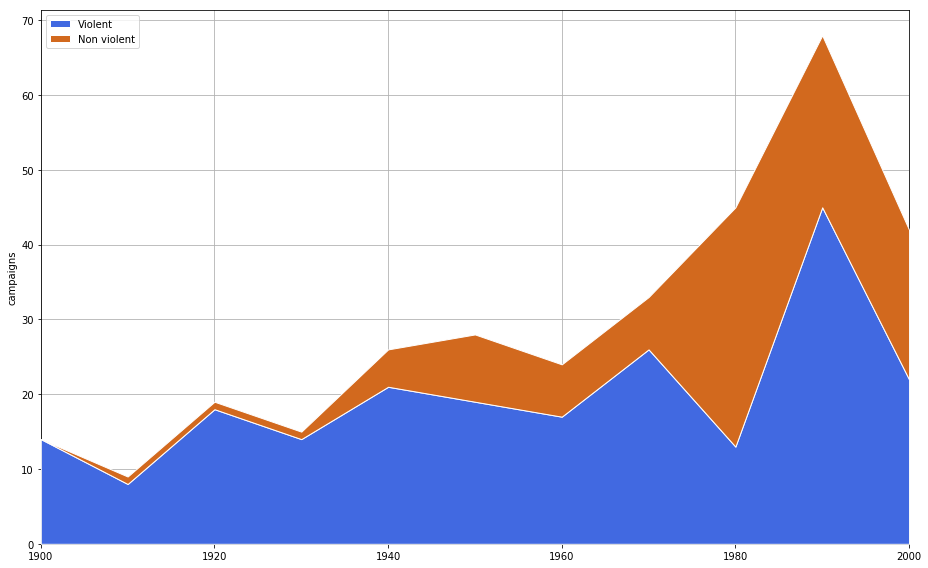

In [6]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.stackplot(decades, val1, val2, labels=['Violent', 'Non violent'],colors=['royalblue','chocolate'],alpha=1,edgecolor='white',zorder=10)
ax.legend(loc='upper left')
ax.set_ylabel('campaigns')
ax.set_xlim(xmin=decades[0], xmax=decades[-1])
plt.xticks(dc)
ax.grid(True)
ax.grid(zorder=0)
fig.tight_layout()
plt.show()

## 2: Number of Nonviolent Campaigns and Percentage of Success

Create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success. Your plot will have two vertical axes, one for each of the metrics, and it should look like this:

<img src="fig_2.svg"/>

# Answer 2:

Εδώ, φτιάχνουμε τον pivot table θέτοντας σαν δείκτη του το πεδίο nonviol. Επίσης, θεωρούμε σαν στήλες του pivot table τις δεκαετίας των campaigns. Για κάθε δεκαετία έχουμε σαν τιμή το σύνολο των εκστρατειών που ήταν επιτυχείς. Από τον παρακάτω pivot table μας ενδιαφέρουν μόνο οι τιμές όπου nonviol=1 δηλαδή μόνο οι μη βίαιες εκστρατείες. 

In [7]:
pv2 = pd.pivot_table(data, values='success', index=['nonviol'], 
                    columns=10*(data['eyear']//10),fill_value=0, aggfunc= np.sum)
pv2

eyear,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
nonviol,,,,,,,,,,,
0,1,2,2,2,7,7,4,10,5,12,3
1,0,0,1,1,2,3,3,4,17,12,14


Μετατρέπουμε τον pivot table σε dataframe ώστε να τον διαχειριζόμαστε καλύτερα όπου ο δείκτης nonviol  γίνεται στήλη. Επιπλέον, παίρνουμε ως val1 μεταβλητή το σύνολο των επιτυχημένων ανά δεκαετία  μη βίαιων επαναστάσεων από την δεκαετία του 1940 και μετά και από την μεταβλητή decades που είχαμε δημιουργήσει και χρησιμοποιήσει στο ερώτημα 1 παίρνουμε μόνο τις δεκαετίες από το 1940 και μετά. Επίσης, έχουμε και την val2 όπου σε αυτήν αποθηκεύουμε το σύνολο των όλων των μη βίαιων επαναστάσεων ανά δεκαετία κρατώντας μόνο από την δεκαετία του 1940 και μετά. Τέλος, χρησιμοποιώντας τις μεταβλητές val1 και val2 αποθηκεύουμε στην y μεταβλητή το ποσοστό των επιτυχημένων μη βίαιων επαναστάσεων από την δεκαετία 1940 και έπειτα.

In [8]:
flat = pd.DataFrame(pv2.to_records())
val1=(flat.iloc[1,5:]).values
val2 = (flattened.iloc[1,6:]).values
y=val1/val2
dec=decades[4:]
dec=dec.astype(int)

Δημιουργία του barplot όπου έχουμε στον άξονα x τις δεκαετίες από το 1940 και μετά και στον άξονα y αριστερά την κλίμακα του συνόλου των μη βίαιων επαναστάσεων από την δεκαετία του 1940 και έπειτα ενώ στην δεξιά πλευρά του άξονα y την κλίμακα του ποσοστού των επιτυχημένων μη βίαιων επαναστάσεων από την δεκαετία του 1940 και έπειτα. Ουσιαστικά οι μπλέ μπάρες έχουν σαν κλίμακα τον αριστερό άξονα y και οι πορτοκαλί μπάρες τον δεξί άξονα y. Παρατηρείται ότι σχεδόν σε κάθε δεκαετία από αυτές το ποσοστό επιτυχίας των μη βίαιων εκστρατειών είναι αρκετά ψηλό, ώντας πολλές φορές πάνω από 40%

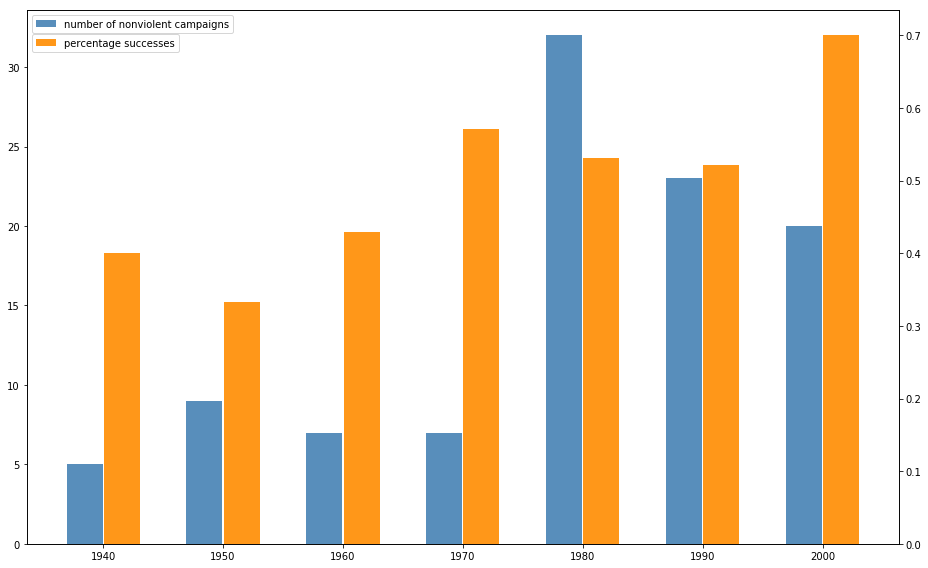

In [9]:
# create plot
fig, ax= plt.subplots(figsize=(13, 8))
bar_width = 3
opacity = .9
bw=1.55
rects1 = ax.bar(dec-bw, val2, bar_width,alpha=opacity,label='number of nonviolent campaigns',color='steelblue')
ax2 = ax.twinx()
rects2 = ax2.bar(dec + bw, y, bar_width,alpha=opacity,color='darkorange',label='percentage successes')
ax.legend(loc='upper left')
ax2.legend(loc='upper left',bbox_to_anchor=(0., 0., 0, 0.964))
plt.tight_layout()
plt.show()

## 3: Success Rate by Decade

Create a plot showing the success rate for violent and nonviolent campaigns by decade. Your plot should look like this, showing that nonviolent campaigns have higher success probabilities:

<img src="fig_3.svg" />

# Answer 3:

Εργαζόμαστε περίπου όπως στις ασκήσεις 1 και 2. Εδώ δημιουργούμε έναν ακόμα pivot table όπου θέτουμε σαν δείκτη του το πεδίο viol. Επίσης, θεωρούμε σαν στήλες του pivot table τις δεκαετίας των campaigns. Για κάθε δεκαετία έχουμε σαν τιμή το σύνολο των εκστρατειών που ήταν επιτυχείς. Από τον παρακάτω pivot table μας ενδιαφέρουν μόνο οι τιμές όπου viol=1 δηλαδή μόνο οι  βίαιες εκστρατείες. Ουσιαστικά κάνουμε την ίδια διαδικασία με την άσκηση 2 μόνο που εδώ ενδιαφερόμαστε για την επιτυχία των βίαιων επαναστάσεων.

In [10]:
pv3 = pd.pivot_table(data, values='success', index=['viol'], 
                    columns=10*(data['eyear']//10),fill_value=0, aggfunc= np.sum)
pv3

eyear,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
viol,,,,,,,,,,,
0,0,0,1,1,2,3,3,4,17,12,14
1,1,2,2,2,7,7,4,10,5,12,3


Πάλι, μετατρέπουμε τον pivot table σε dataframe ώστε να τον διαχειριζόμαστε καλύτερα όπου ο δείκτης viol γίνεται στήλη. Επιπλέον, παίρνουμε ως val3 μεταβλητή το σύνολο των επιτυχημένων ανά δεκαετία βίαιων επαναστάσεων από την δεκαετία του 1940 και μετά. Επίσης, έχουμε και την val4 όπου σε αυτήν αποθηκεύουμε το σύνολο όλων των  βίαιων επαναστάσεων ανά δεκαετία κρατώντας μόνο από την δεκαετία του 1940 και μετά. Τέλος, χρησιμοποιώντας τις μεταβλητές val3 και val4 αποθηκεύουμε στην y2 μεταβλητή το ποσοστό των επιτυχημένων  βίαιων επαναστάσεων από την δεκαετία 1940 και έπειτα.

In [11]:
flat2 = pd.DataFrame(pv3.to_records())
val3=flat2.iloc[1,5:].values
val4 = (flattened.iloc[0,6:]).values
y2=val3/val4

Δημιουργία του barplot όπου έχουμε στον άξονα x τις δεκαετίες από το 1940 και μετά και στον άξονα y το ποσοστό των επιτυχημένων εκστρατειών. Με την απόχρωση του πορτοκαλί χρώματος φαίνονται το ποσοστό επιτυχίας των βίαιων επαναστάσεων ανά δεκαετία ενώ με μπλε φαίνονται ο ποσοστό επιτυχίας των μη βίαιων επαναστάσεων ανά δεκαετία. Σχεδόν ολοκληρωτικά βλέπουμε ότι έχουμε μεγαλύτερο ποσοστό επιτυχημένων μη βίαιων επαναστάσεων από ότι βίαιες σχεδόν κάθε δεκαετία με εξαίρεση μόνο την δεκαετία 1950. Το γεγονός αυτό ίσως να μην είναι και τόσο περίεργο καθώς όπως είδαμε και στην άσκηση 1 έιχαμε περισσότερες μη βίαιες επαναστάσεις ανά δεκαετία από ότι βίαιες ανεξαρτήτου αποτελέσματος.

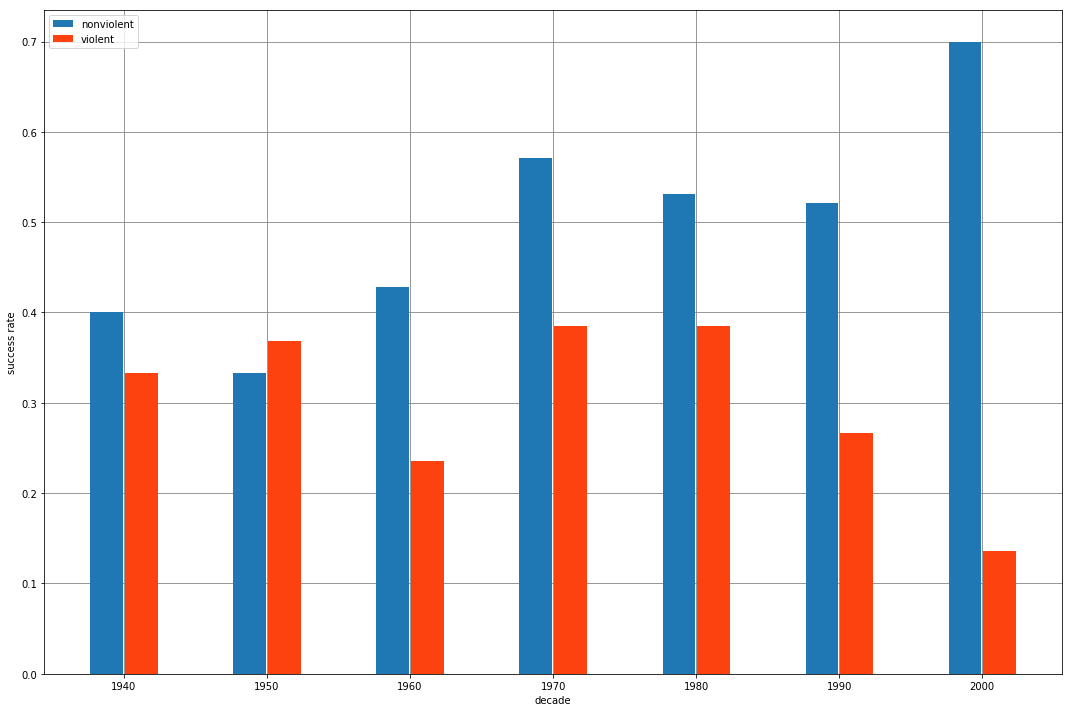

In [12]:
fig, ax= plt.subplots(figsize=(15, 10))
ax.grid(b=False, which='major', color='gray', linestyle='-')
ax.set_axisbelow(True)
bar_width = 2.3
opacity = 1
bw=1.2
ax.bar(dec-bw, y, bar_width,alpha=opacity,label='nonviolent')
ax.bar(dec + bw, y2, bar_width,alpha=opacity,color='xkcd:orangered',label='violent')
ax.legend(loc='upper left')
plt.ylabel('success rate')
plt.xlabel('decade')
plt.tight_layout()
plt.show()

## 4. Twenty-Five Largest Resistance Campaigns, 1900-2006

Create a table with the twenty-five largest resistance campaigns, for all years, based on their number of members at highest point (peak membership). The table should include the membership, the start year, the end year, the location, the target, whether it was violent or not, and whether it was successful or not. Notice if you find anything about Greece.

# Answer 4:

Με την χρήση της nlargest μεθόδου του pandas βρίσκουμε και εμφανίζουμε τις 25 μεγαλύτερες campaigns από το 1900 μέχρι το 2006 οι οποίες έχουν το μεγαλύτερο αριθμό συμμετεχόντων μεταξύ των άλλων campaigns. Ο αριθμός αυτός ουσιαστικά αφορά τον μέγιστο αριθμό συμμετεχόντων που καταγράφτηκε σε κάθε εκστρατεία όταν ήταν στο peak της.

In [13]:
data[['peakmembership','eyear','byear','location','target','nonviol','viol','success','failure']].nlargest(25, ['peakmembership'])

,peakmembership,eyear,byear,location,target,nonviol,viol,success,failure
257,4500000.0,1945,1937,China,Japanese occupation,0,1,0,1
206,2000000.0,1979,1977,Iran,Shah Reza Pahlavi,1,0,1,0
311,2000000.0,1983,1986,Philippines,Ferdinand Marcos,1,0,1,0
10,1000000.0,2006,2006,Mexico,Calderon regime,1,0,0,1
38,1000000.0,1985,1984,Brazil,Military rule,1,0,1,0
141,1000000.0,1999,1993,Nigeria,Military rule,1,0,1,0
228,1000000.0,2005,2005,Lebanon,Syrian forces,1,0,1,0
255,1000000.0,1949,1922,China,Kuomintang regime,0,1,1,0
262,1000000.0,1968,1967,China,anti-Maoists,0,1,0,1
265,1000000.0,1989,1989,China,Communist regime,1,0,0,1


Βλέπουμε ότι μία εκ των 25 επαναστάσεων με τους περισσότερους συμμετέχοντες κατά το peak τους είναι και η επανάσταση που συνέβει στην Ελλάδα κατά το 1963 κατά της κυβερνήσεως του Καραμανλή που όπως γνωρίζουμε οδήγησε μετά στην δικτατορία των συνταγματαρχών ή αλλιώς στην γνωστή χούντα.

## 5. The Effect of Participation on the Probability of Campaign Success

Examine the effect of participation on the probability of campaign success. You should run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends. Explain your results.

Having done that, create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axis. Your plot should look like this:

<img src="fig_4.svg" />

# Answer 5:

Σε ένα dataframe με όνομα dt αποθηκεύουμε τις εγγραφές του αρχικού μας dataframe για τις οποίες οι τιμές των στηλών lnpop και mempc δεν είναι Nan

In [14]:
dt = data.loc[(data['lnpop'].notna())&(data['mempc'].notna())]

Έπειτα, θεωρώντας σαν εξαρτημένη μεταβλητή την στήλη success και σαν ανεξάρτητες τις στήλες mempc και lnpop εφαρμόζουμε λογιστική παλινδρόμηση χρησιμοποιώντας το dataframe που ορίσαμε στο από πάνω κελί. Τέλος, εκτυπώνουμε τον πίνακα με κάποια χρήσιμα στοιχεία για την λογιστική παλινδρόμηση και τους παράγοντες για κάθε μία από τις ανεξάρτητες μεταβλητές. 

In [15]:
success_mod = logit("success ~ mempc + lnpop", dt).fit()
success_mod.summary2()

Optimization terminated successfully.
         Current function value: 0.594790
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.129     
Dependent Variable: success          AIC:              199.9014  
Date:               2019-12-02 00:32 BIC:              209.1827  
No. Observations:   163              Log-Likelihood:   -96.951   
Df Model:           2                LL-Null:          -111.35   
Df Residuals:       160              LLR p-value:      5.5508e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -5.8199    1.9207  -3.0301  0.0024  -9.5843  -2.0555
mempc          4.4892    0.9857   4.5545  0.0000   2.5573   6.4210
lnpop          0.0907    0.1285   0.7058  0.4803  -0.1612   0.3426
=================================================================

"""

* One unit increase in mempc brings an increase of 4.4892 in the log odds of having an affair; equivalently, the odds ratio increases by $e^{4.4892} \approx 89.05$.

* One unit increase in the lnpop brings an increase of 0.0907 in the log odds of having an affair; equivalently, the odds ratio increases by $e^{0.0907} \approx 1.09 $ or about 11%.

* The intercept is the log odds of having an affair when all the independent variables are held at zero; that is $e^{-5.8199} \approx 0.003‬ $. That means that $p  /  (1-p) = 0.003$, or $p \approx 0.003$.

Στην μεταβλητή pred ουσιαστικά αποθηκεύουμε τις προβλέψεις που εξάχθηκαν από το μοντέλο της λογιστικής παλινδρόμησης για κάθε ένα παράδειγμα του dataframe μας. Όπου ουσιαστικά αυτή η πρόβλεψη αφορά την πιθανότητα για την οποία μια επανάσταση δηλαδή μία εγγραφή μπορεί να είναι επιτυχής.

In [16]:
pred=success_mod.predict() 
print(pred)

[0.61957279 0.58643815 0.42994806 0.14691383 0.18985849 0.38802933
 0.36884643 0.53791108 0.16213648 0.22904883 0.62778298 0.63868491
 0.24704815 0.09073522 0.46820505 0.62315966 0.80727978 0.20306993
 0.29795555 0.35985261 0.72618584 0.43058488 0.54162019 0.28970351
 0.43646642 0.51210151 0.80119534 0.74705875 0.39987414 0.37313019
 0.36127578 0.71732258 0.82008222 0.24361703 0.22155509 0.62427573
 0.52084536 0.56011923 0.36103918 0.5830031  0.92701883 0.8773812
 0.84764011 0.6508325  0.65010597 0.37286524 0.80083714 0.40701888
 0.76402031 0.35064475 0.67235692 0.30674419 0.4023827  0.48552571
 0.37403436 0.57244361 0.5783141  0.44668418 0.37473268 0.41495932
 0.11498547 0.53200595 0.6348709  0.22222089 0.34890953 0.17658923
 0.32851911 0.22571605 0.12624966 0.32984699 0.11679193 0.33074366
 0.55181572 0.27230962 0.27832721 0.45960526 0.45715555 0.24328959
 0.36686986 0.73937973 0.39449675 0.34390814 0.36626552 0.29130235
 0.4058208  0.56788167 0.38313461 0.43428494 0.50487453 0.18106

Τέλος, δημιουργούμε το scatter plot όπου στον άξονα y έχουμε τις πιθανότητες μία επανάσταση να είναι επιτυχής και στον άξονα x τον αριθμό των συμμετεχόντων κατά κεφαλή σε κάθε επανάσταση.

Text(0, 0.5, 'Probability of success')

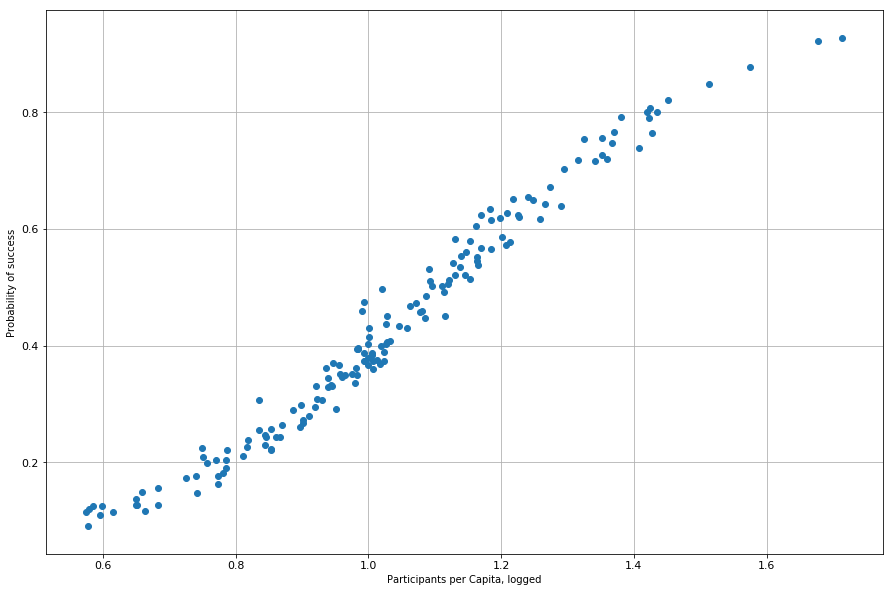

In [17]:
dt.reset_index(drop=True, inplace=True)
x=dt.loc[:,['mempc']]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(x,pred,zorder=3)
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
ax.grid(True)
ax.grid(zorder=0)
ax.set_xlabel('Participants per Capita, logged')
ax.set_ylabel('Probability of success')

Ωστόσο, τα δεδομένα αποκαλύπτουν ένα μοτίβο. Μεγάλες επαναστάσεις είναι πολύ πιο πιθανό να επιτύχουν από τις μικρές εκστρατείες. Μια αύξηση της μίας μονάδας των συμμετεχόντων κάνουν μια εκστρατεία άνω του 10% πιο πιθανό να επιτύχουν τον τελικό τους σκοπό. Παρόλα αυτά, γνωρίζουμε ότι μόνο οι αριθμοί δεν εγγυώνται τη νίκη μιας εκστρατείας. Όπως δείχνουν ορισμένες περιπτώσεις, ένας μεγάλος αριθμός συμμετεχόντων δεν την κάνει αυτόματα επιτυχής. Απλά έχουμε μεγαλύτερη πιθανότητα ώστε να υπάρχει επιτυχής κατάλληξη.

## 6. The Level of Participation Tipping Point

From the results you obtained in the previous question, find the percentage of the population that is the tipping point for success in a campaign.

# Answer 6:

Αρχικά να τονίσουμε το προφανές ότι καθώς η πιθανότητα επιτυχίας για μια επανάσταση αυξάνεται άνω του 0.5 τότε έχει όλο και μεγαλύτερη πιθανότητα να είναι επιτυχής η επανάσταση αυτή. Οπότε παρακάτω προσθέτουμε την στήλη prediction με τις πιθανότητες επιτυχίας για κάθε επανάσταση στο dataframe. Από τις εγγραφές διαλέγουμε μόνο όσες έχουν prediction>0.5 και δημιουργούμε το scatter plot για αυτές. Φαίνεται πολύ καλά ότι για τις εγγραφές με συμμετέχοντες κατά κεφαλή περίπου 1.09 και κυρίως άνω του 1.1 τότε όλο όσο μεγαλώνουν οι συμμετέχοντες κατά κεφαλή πέρα από αυτή την τιμή τόσο αυξάνεται η πιθανότητα επιτυχίας μίας επανάστασης. Οπότε το κρίσιμο σημείο όπου βλέπουμε ότι οι πιθανότητες επιτυχίες είναι μεγαλύτερες από ότι αποτυχίας είναι από την τιμή 1.09 και πάνω. Οπότε θέλουμε περίπου να αντιστοιχούν για κάθε άτομο περίπου 1.09 άτομα και παραπάνω, άρα μιλάμε για ένα ποσοστό της τάξεως του 109% του πληθυσμού και άνω.

In [18]:
d2 = dt.copy()
d2['predictions']=pred
d_sel = d2[d2['predictions']>0.5]
mn=min(d_sel['predictions'])
d_sel[['mempc','predictions']].nsmallest(5, ['predictions'])

,mempc,predictions
107,1.110516,0.501905
149,1.096068,0.502808
88,1.119458,0.504875
132,1.092927,0.510537
25,1.121430,0.512102


Text(0, 0.5, 'Probability of success')

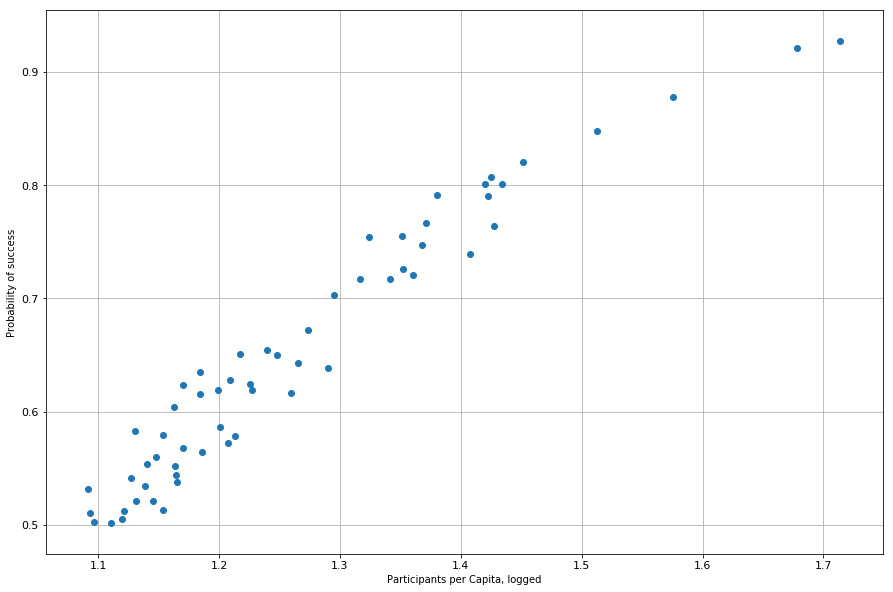

In [19]:
s1,s2 = x.shape
x=np.array(x).reshape(s1,s2)
x = x.reshape(s1)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(d_sel.loc[:,['mempc']],d_sel.loc[:,['predictions']],zorder=3)
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
ax.grid(True)
ax.grid(zorder=0)
ax.set_xlabel('Participants per Capita, logged')
ax.set_ylabel('Probability of success')

Εδώ βλέπουμε ότι το σκιαγραμμένο επίπεδο δείχνει τις τιμές για τις οποίες μιλήσαμε παραπάνω, όπου οι πιθανότητες μία επανάστασης να είναι επιτυχής είναι περισσότερες από το να αποτύχει. Οι 2 κόκκινες γραμμές οριοθετούν τα όρια όπου η πιθανότητα είναι μεγαλύτερη του 0.5 και οι κατα κεφαλήν συμμετέχοντες ίσοι ή περισσότεροι του 1.09 

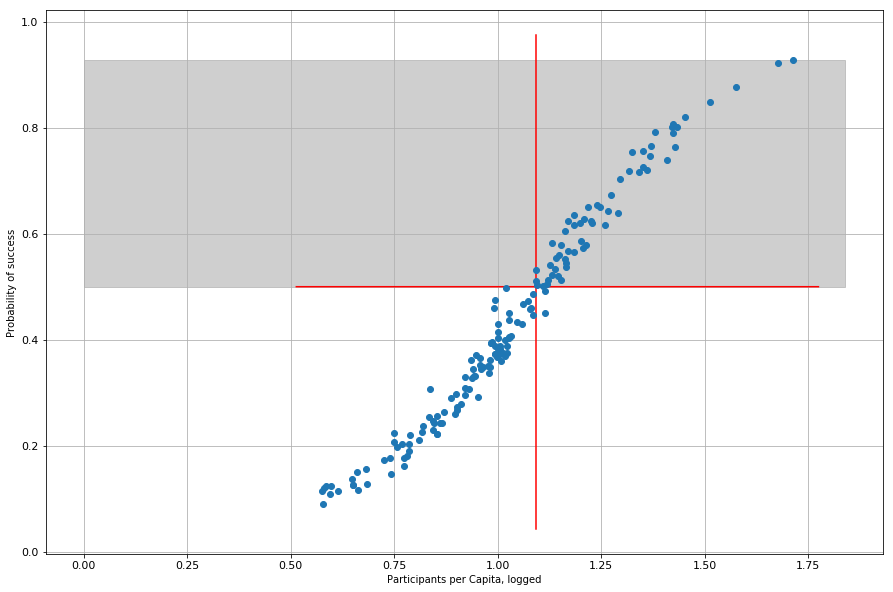

In [20]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(x,pred,zorder=3)
ax.plot(ax.get_xlim(), [0.500001,0.50001], color='red')
ax.plot([1.092,1.092], ax.get_ylim(), color='red')
l,r = ax.get_xlim()
ax.fill_between([0,r], 0.50, max(pred), color='#888888', alpha=0.4)
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
ax.grid(True)
ax.grid(zorder=0)
ax.set_xlabel('Participants per Capita, logged')
ax.set_ylabel('Probability of success')
plt.show()

## 7. Nonviolent Resistance, Target Regime Type, Geographical Location

1. Examine whether nonviolent resistance remains significant even if we control for the regime type. Run a logistic   regression of success on the nonviolence indicator controlling for the POLITY IV score of campaign target (`tpolity`), the log of peakmembership, and the location’s logged population the year the campaign ends.

2. Examine whether nonviolent resistance remains significant even if we control for geographical location of the compaign.

# Answer 7.1

Σε ένα dataframe με όνομα new_dt αποθηκεύουμε τις εγγραφές του αρχικού μας dataframe για τις οποίες οι τιμές των στηλών lnpop, lmembers, και tpolity δεν είναι Nan και η τιμή της στήλης nonviol=1. Άρα ενδιαφερόμαστε μόνο για τις μη βίαιες επαναστάσεις εδώ και την πιθανότητα επιτυχίας αυτών.

In [21]:
new_dt = data.loc[(data['tpolity'].notna())&(data['nonviol']==1)&(data['lmembers'].notna())&(data['lnpop'].notna())]
new_dt.head()

,defect,outcome,peakmembership,eyear,byear,location,campaign,target,lccode,tccode,...,lmtnest,ef,loclpolity1,loclcap1,loclcap2,loclcap3,loclcap4,mempc,demdum,recur1
2,1.0,5,30000.0,1985,1985,Haiti,,Jean Claude Duvalier,41.0,41.0,...,2.797281,0.095000,-9.0,1.0,0.0,0.0,0.0,1.200712,0.0,0.0
9,1.0,5,100000.0,2000,1987,Mexico,,corrupt govt,70.0,70.0,...,3.471967,0.541779,-3.0,0.0,0.0,0.0,1.0,1.001202,NaN,0.0
24,0.0,3,400.0,1989,1987,Panama,,Noriega regime,95.0,95.0,...,2.564949,0.506700,-6.0,1.0,0.0,0.0,0.0,0.774153,0.0,0.0
31,1.0,5,200000.0,2002,2002,Venezuela,anti-coup,anti-Chavez coup,101.0,101.0,...,NaN,NaN,6.0,0.0,0.0,1.0,0.0,1.208794,0.0,0.0
32,1.0,5,5000.0,1992,1990,Guyana,,Burnham/Hoyte autocratic regime,110.0,110.0,...,1.193922,0.619563,-7.0,1.0,0.0,0.0,0.0,1.289875,0.0,0.0


Έπειτα, θεωρώντας σαν εξαρτημένη μεταβλητή την στήλη success και σαν ανεξάρτητες τις στήλες tpolity, lmembers και lnpop. Εφαρμόζουμε λογιστική παλινδρόμηση χρησιμοποιώντας το dataframe που ορίσαμε στο από πάνω κελί. Τέλος, εκτυπώνουμε τον πίνακα με κάποια χρήσιμα στοιχεία για την λογιστική παλινδρόμηση και τους παράγοντες για κάθε μία από τις ανεξάρτητες μεταβλητές. 

In [22]:
nviolent_mod = logit("success ~ tpolity + lmembers + lnpop", new_dt).fit()
nviolent_mod.summary2()

Optimization terminated successfully.
         Current function value: 0.545562
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.189    
Dependent Variable: success          AIC:              68.0118  
Date:               2019-12-02 00:32 BIC:              76.0412  
No. Observations:   55               Log-Likelihood:   -30.006  
Df Model:           3                LL-Null:          -37.016  
Df Residuals:       51               LLR p-value:      0.0028788
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept     0.4815    2.4458   0.1969  0.8439  -4.3121   5.2752
tpolity       0.0326    0.0646   0.5048  0.6137  -0.0939   0.1591
lmembers      0.5215    0.1966   2.6518  0.0080   0.1361   0.9069
lnpop        -0.5744    0.2367  -2.4269  0.0152  -1.0383  -0.1105
================================================================

"""

Τέλος, δημιουργούμε το scatter plot όπου στον άξονα y έχουμε τις πιθανότητες μία επανάσταση να είναι επιτυχής και στον άξονα x τον αριθμό κάθε καθεστώτος. Αυτός ο αριθμός κυμαίνεται από το -10 εως το 10. Όσο πιο μεγάλος είναι τόσο πιο δημοκρατικό καθεστός έχουμε. Ενώ, όσο πιο μικρός είναι τόσο πιο απολυταρχικό καθεστός έχουμε. Η πράσινη περιοχή σκιαγραφεί την περιοχή όπου η πιθανότητα επιτυχίας της επανάστασης είναι άνω του 50% και το καθεστός είναι λιγότερο απολυταρχικό και όλο πιο δημοκρατικό όσο αυξάνεται η τιμή του στον άξονα x. Ενώ  η κόκκινη περιοχή σκιαγραφεί την περιοχή όπου η πιθανότητα επιτυχίας της επανάστασης είναι άνω του 50% και το καθεστός είναι ολοένα  περισσότερο απολυταρχικό και λιγότερο δημοκρατικό όσο αυξάνεται η τιμή του στον άξονα x. Αρχικά παρατηρούμε ότι έχουμε σημαντικά περισσότερες επαναστάσεις όσο το πολίτευμα είναι πιο απολυταρχικό από ότι όταν έχουμε ένα δημοκρατικό πολίτευμα και ότι έχουμε αρκετές επαναστάσεις σε ένα απολυταρχικό καθεστός που έχουν αρκετά αξιόλογη πιθανότητα επιτυχίας. 

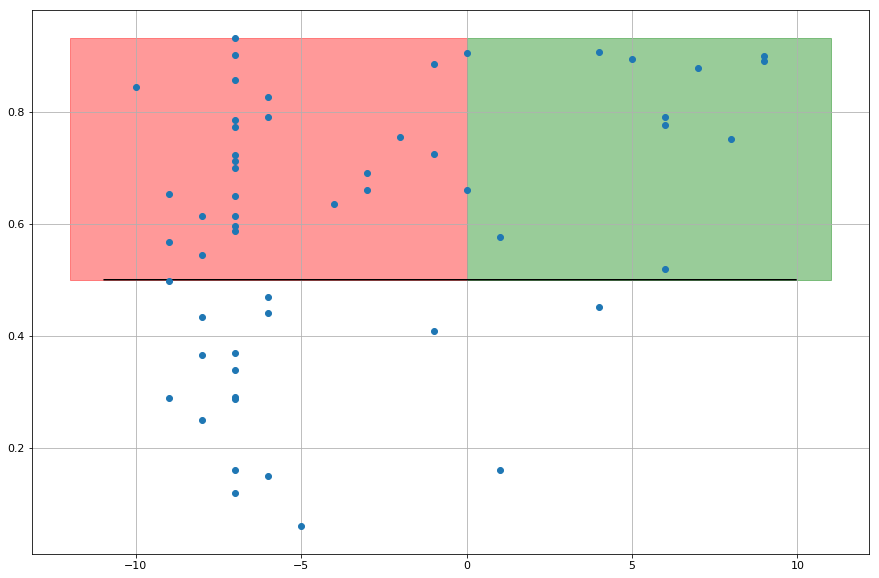

In [23]:
new_dt.reset_index(drop=True, inplace=True)
pred=nviolent_mod.predict() 
x=new_dt.loc[:,['tpolity']]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(x,pred,zorder=3)
ax.plot(ax.get_xlim(), [0.500001,0.50001], color='black')
l,r = ax.get_xlim()
ax.fill_between([l,0], 0.50, max(pred), color='red', alpha=0.4)
ax.fill_between([0,r], 0.50, max(pred), color='green', alpha=0.4)
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
ax.grid(True)
ax.grid(zorder=0)

# Answer 7.2

Σε ένα dataframe με όνομα new1_dt2 αποθηκεύουμε τις εγγραφές του αρχικού μας dataframe για τις οποίες η τιμή της στήλης nonviol=1. Άρα ενδιαφερόμαστε μόνο για τις μη βίαιες επαναστάσεις εδώ και την πιθανότητα επιτυχίας αυτών.

In [24]:
new1_dt2 = data.loc[(data['nonviol']==1)]
new1_dt2.head()

,defect,outcome,peakmembership,eyear,byear,location,campaign,target,lccode,tccode,...,lmtnest,ef,loclpolity1,loclcap1,loclcap2,loclcap3,loclcap4,mempc,demdum,recur1
2,1.0,5,30000.0,1985,1985,Haiti,,Jean Claude Duvalier,41.0,41.0,...,2.797281,0.095000,-9.0,1.0,0.0,0.0,0.0,1.200712,0.0,0.0
9,1.0,5,100000.0,2000,1987,Mexico,,corrupt govt,70.0,70.0,...,3.471967,0.541779,-3.0,0.0,0.0,0.0,1.0,1.001202,NaN,0.0
10,0.0,3,1000000.0,2006,2006,Mexico,,Calderon regime,70.0,70.0,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
11,1.0,5,NaN,1944,1944,Guatemala,October Revolutionaries,Ubico dictatorship,90.0,90.0,...,NaN,NaN,-9.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN
17,1.0,5,NaN,1944,1944,El Salvador,Strike of Fallen Arms,Martinez dictatorship,92.0,92.0,...,NaN,NaN,-9.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN


Έπειτα, θεωρώντας σαν εξαρτημένη μεταβλητή την στήλη success και σαν ανεξάρτητες τις στήλες middleeast americas asia fsu europe africa. Εφαρμόζουμε λογιστική παλινδρόμηση χρησιμοποιώντας το dataframe που ορίσαμε στο από πάνω κελί. Τέλος, εκτυπώνουμε τον πίνακα με κάποια χρήσιμα στοιχεία για την λογιστική παλινδρόμηση και τους παράγοντες για κάθε μία από τις ανεξάρτητες μεταβλητές. 

In [25]:
nviolent0_mod2 = logit('success ~ middleeast+americas+asia+fsu+europe+africa', new1_dt2).fit()
nviolent0_mod2.summary2()

Optimization terminated successfully.
         Current function value: 0.606986
         Iterations 5


C:\Users\IAKOVOS\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\IAKOVOS\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.121    
Dependent Variable: success          AIC:              140.6811 
Date:               2019-12-02 00:32 BIC:              156.6617 
No. Observations:   106              Log-Likelihood:   -64.341  
Df Model:           5                LL-Null:          -73.171  
Df Residuals:       100              LLR p-value:      0.0034016
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
------------------------------------------------------------------
                 Coef.    Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept        0.2656        nan   nan     nan      nan      nan
middleeast      -0.6711        nan   nan     nan      nan      nan
americas         1.3438        nan   nan     nan      nan      nan
asia            -1.2101        nan   nan     nan      nan      nan
fsu              1.1207        nan   nan     nan      nan      nan
europe          -0.3397        nan   nan     nan      nan      nan
africa           0.0221        nan   nan     nan      nan      nan
================================================================

"""

Εδώ κάνουμε μία πιο ειδική ουσιαστικά μελέτη θέλοντας να μελετήσουμε την εξάρτηση της επιτυχίας από την χώρα που γίνεται η επανάσταση και όχι απλά την ήπειρο. Για αυτό σε ένα dataframe με όνομα new_dt2 αποθηκεύουμε τις εγγραφές του αρχικού μας dataframe για τις οποίες η τιμή της στήλης nonviol=1 και η στήλη location να μην έχει τιμές Νan. Άρα ενδιαφερόμαστε μόνο για τις μη βίαιες επαναστάσεις εδώ και την πιθανότητα επιτυχίας αυτών. Επιπλέον, επειδή οι τιμές της στήλης location είναι κατηγορηματικές  χτησιμοποιούμε την μέθοδο get_dummies για να κάνουμε ουσιαστικά one hot enconding.

In [26]:
e_dt2 = data.loc[(data['location'].notna())&(data['nonviol']==1)&(data['success'].notna())]
e_dt2=pd.get_dummies(e_dt2, prefix=['location'], columns=['location'],drop_first=True)
e_dt2.columns = e_dt2.columns.str.replace(' ', '_')
e_dt2.head()

,defect,outcome,peakmembership,eyear,byear,campaign,target,lccode,tccode,nonviol,...,location_Taiwan,location_Tanzania,location_Thailand,location_Tibet,location_Ukraine,location_Uruguay,location_Venezuela,location_West_Papua,location_Yugoslavia,location_Zambia
2,1.0,5,30000.0,1985,1985,,Jean Claude Duvalier,41.0,41.0,1,...,0,0,0,0,0,0,0,0,0,0
9,1.0,5,100000.0,2000,1987,,corrupt govt,70.0,70.0,1,...,0,0,0,0,0,0,0,0,0,0
10,0.0,3,1000000.0,2006,2006,,Calderon regime,70.0,70.0,1,...,0,0,0,0,0,0,0,0,0,0
11,1.0,5,NaN,1944,1944,October Revolutionaries,Ubico dictatorship,90.0,90.0,1,...,0,0,0,0,0,0,0,0,0,0
17,1.0,5,NaN,1944,1944,Strike of Fallen Arms,Martinez dictatorship,92.0,92.0,1,...,0,0,0,0,0,0,0,0,0,0


Με αυτή την μέθοδο κρατάμε μόνο τις μεταβλητές του location (μεταβλητές με πρόθεμα το location).

In [27]:
def r3move(cl):
    clm = list()
    for i in cl:
        if i.startswith('location_'):
            clm.append(i)
    return clm         

In [28]:
clmns = r3move(list(e_dt2.columns))
frm = "success ~ " + '+'.join(clmns)

Έπειτα, θεωρώντας σαν εξαρτημένη μεταβλητή την στήλη success και σαν ανεξάρτητες τις στήλες όλες αυτές που δημιουργήθηκαν από το get_dummies και ουσιαστικά είναι όλες οι k-1 τιμές της στήλης location. Εφαρμόζουμε λογιστική παλινδρόμηση χρησιμοποιώντας το dataframe που ορίσαμε στο παραπάνω κελί. Τέλος, εκτυπώνουμε τον πίνακα με κάποια χρήσιμα στοιχεία για την λογιστική παλινδρόμηση και τους παράγοντες για κάθε μία από τις ανεξάρτητες μεταβλητές. 

In [29]:
nviolent_mod2 = logit(formula=frm, data=e_dt2).fit(method='bfgs')
nviolent_mod2.summary2()

         Current function value: 0.213495
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\IAKOVOS\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                     Logit                 Pseudo R-squared:      0.691    
Dependent Variable:        success               AIC:                   185.2609 
Date:                      2019-12-02 00:32      BIC:                   371.7017 
No. Observations:          106                   Log-Likelihood:        -22.630  
Df Model:                  69                    LL-Null:               -73.171  
Df Residuals:              36                    LLR p-value:           0.0071456
Converged:                 0.0000                Scale:                 1.0000   
---------------------------------------------------------------------------------
                         Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------
Intercept                 1.4528     2.5513  0.5695 0.5691     -3.5476     6.4533
location_Argentina       11.1109   378.1704  0.0294 0.9766   -730.0895   752.3113
location_Bangladesh      -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Belarus        -13.0851   237.3701 -0.0551 0.9560   -478.3220   452.1518
location_Benin           -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Bolivia          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Brazil           6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Bulgaria         6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Burma           -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Chile           11.1109   378.1704  0.0294 0.9766   -730.0895   752.3113
location_China          -23.9710 38789.5862 -0.0006 0.9995 -76050.1630 76002.2211
location_Croatia          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Czechoslovakia  -1.6360     2.9199 -0.5603 0.5753     -7.3590     4.0869
location_Denmark         -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_East_Germany    -2.1941     2.8345 -0.7741 0.4389     -7.7495     3.3614
location_East_Timor       6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Egypt           -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_El_Salvador     -1.6360     2.9199 -0.5603 0.5753     -7.3590     4.0869
location_Estonia          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Georgia          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Germany          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Ghana           11.1109   378.1704  0.0294 0.9766   -730.0895   752.3113
location_Greece          11.1109   378.1704  0.0294 0.9766   -730.0895   752.3113
location_Guatemala        6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Guyana           6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Haiti            6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Hungary         -1.6360     2.9199 -0.5603 0.5753     -7.3590     4.0869
location_India           -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Indonesia        6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Iran             6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Israel          -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Kenya           -8.4325    32.9097 -0.2562 0.7978    -72.9342    56.0693
location_Kyrgyzstan      11.1109   378.1704  0.0294 0.9766   -730.0895   752.3113
location_Latvia           6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Lebanon          6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Lithuania        6.5370    54.4001  0.1202 0.9044   -100.0852   113.1592
location_Madagascar      11.1109   378.1704  0.02

Pseudo R-square = 0.691 οπότε έχουμε μία μέτρια συσχέτιση της χώρας με την επιτυχία της επανάστασης.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.